<a href="https://colab.research.google.com/github/jyotz02/Learning/blob/master/Stock%20Price%20Prediction/SPP_ONGC_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df=pd.read_csv("/content/drive/My Drive/ongc.csv")

In [0]:
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))



In [0]:
df.head()

,Date,Close Price
0,11-Jul-18,158.10
1,12-Jul-18,158.95
2,13-Jul-18,154.10
3,16-Jul-18,153.80
4,17-Jul-18,156.15


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


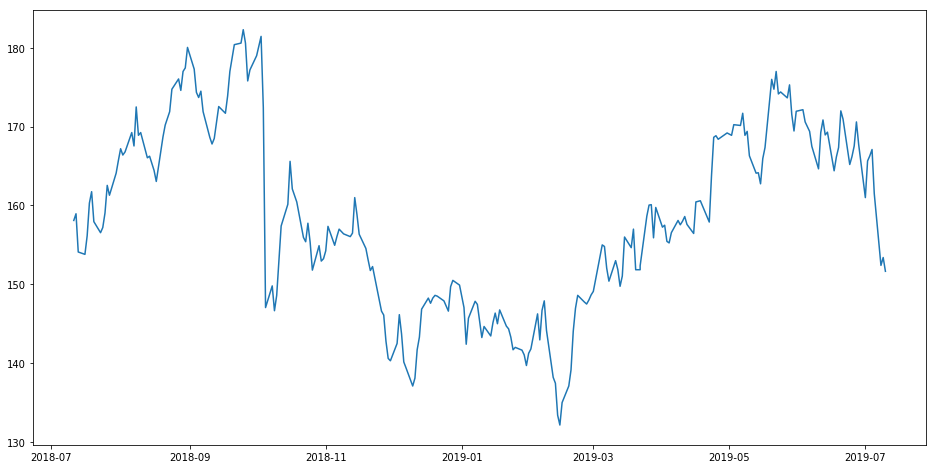

In [0]:
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close Price'], label='Close Price history')

## Moving Average

In [0]:

#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close Price'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close Price'][i] = data['Close Price'][i]

In [0]:
#splitting into train and validation
train = new_data[:180]
valid = new_data[180:]

In [0]:
 train.shape, valid.shape


((180, 2), (66, 2))

In [0]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

(Timestamp('2018-07-11 00:00:00'),
 Timestamp('2019-04-02 00:00:00'),
 Timestamp('2019-04-03 00:00:00'),
 Timestamp('2019-07-10 00:00:00'))

In [0]:
#make predictions
preds = []
for i in range(0,66):
    a = train['Close Price'][len(train)-66+i:].sum() + sum(preds)
    b = a/66
    preds.append(b)

In [0]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Close Price'])-preds),2)))
rms

18.01706732988079

RMSE calculated after making predictions using moving average is quite high as it should be for stock prices. Further, checking the plot for it.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


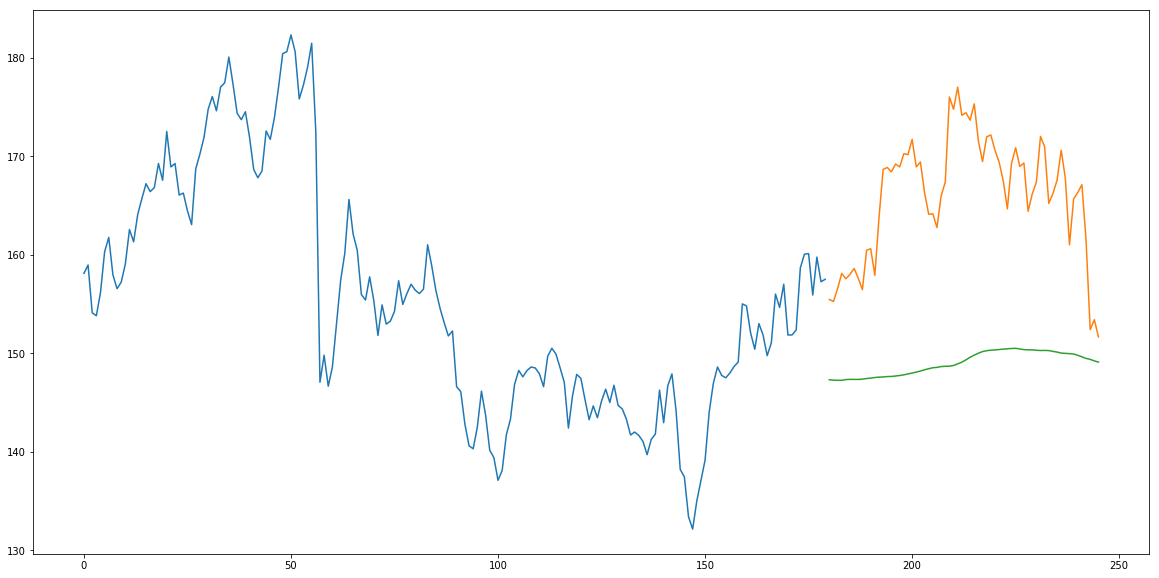

In [0]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close Price'])
plt.plot(valid[['Close Price', 'Predictions']])

## Inference:

Using Moving average, the RMSE score received was quite more and by the above plot we can see that Moving average is not a good option for model building of stock price prediction data.

## Linear regression

In [0]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close Price'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close Price'][i] = data['Close Price'][i]

In [0]:
!pip install fastai==0.7.0

     |████████████████████████████████| 122kB 5.1MB/s 
     |████████████████████████████████| 496.4MB 25kB/s 
     |████████████████████████████████| 1.5MB 31.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [0]:
#create features
from fastai.structured import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

In [0]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
#split into train and validation
train = new_data[:180]
valid = new_data[180:]

x_train = train.drop('Close Price', axis=1)
y_train = train['Close Price']
x_valid = valid.drop('Close Price', axis=1)
y_valid = valid['Close Price']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

26.281633062496056

RMSE score calculated after applying Linear regression is quite high. So, linear regression cannot be used to predict in this case.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


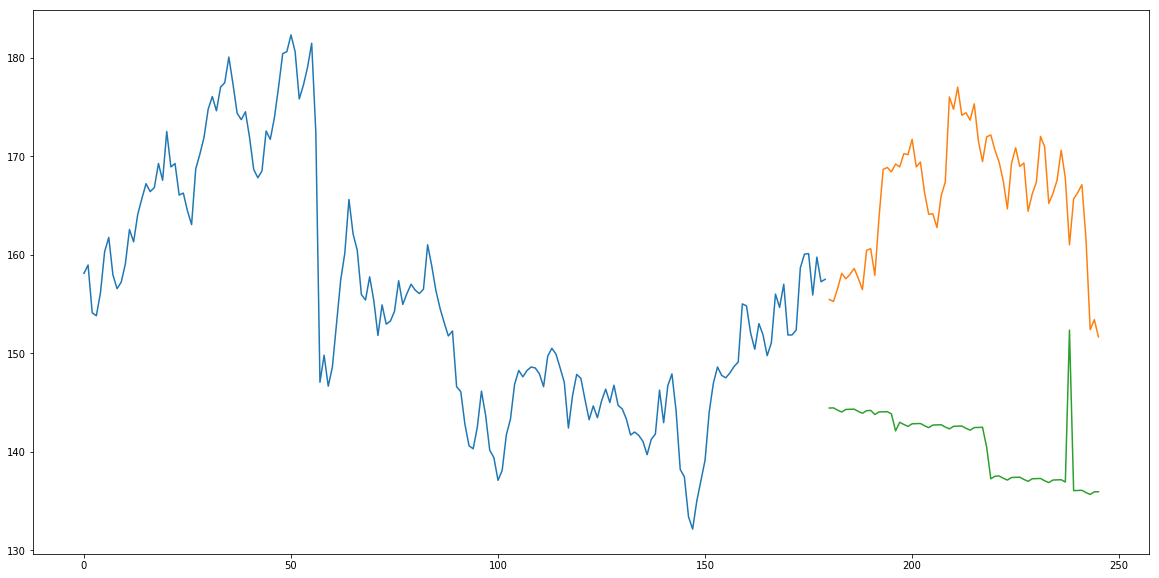

In [0]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[180:].index
train.index = new_data[:180].index

plt.plot(train['Close Price'])
plt.plot(valid[['Close Price', 'Predictions']])

## Inference:

Using linear regression for the above dataset, we can see that model is making not so good prediction, and we can say that linear Reression does't work well for the above dataset.


## K - Nearest Neighbour

In [0]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [0]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [0]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

7.285023761946235

RMSE is reduced by using K-Neighbour Regressor. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


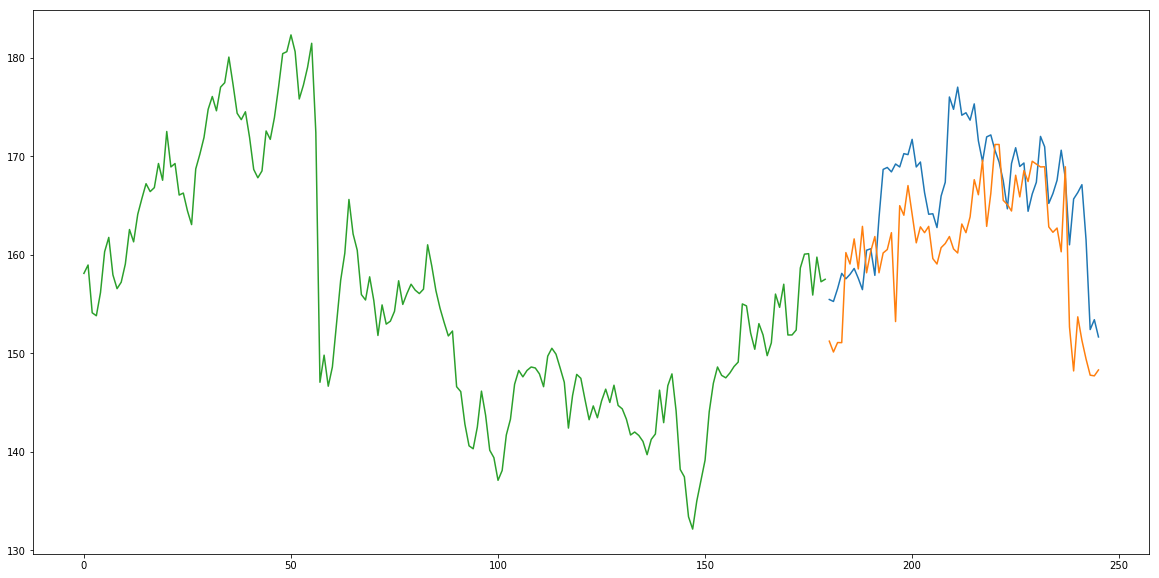

In [0]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close Price', 'Predictions']])
plt.plot(train['Close Price'])

## Inference

Using KNN, the prediction of model has increased as compared to with linear regression and Moving Average.

## Auto Arima

In [0]:
#Installing ARIMA
pip install pyramid-arima

     |████████████████████████████████| 604kB 4.9MB/s 


In [0]:
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:180]
valid = data[180:]

training = train['Close Price']
validation = valid['Close Price']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=66)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=908.102, BIC=923.692, Fit time=1.364 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1006.635, BIC=1012.871, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=954.517, BIC=966.989, Fit time=0.294 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=906.284, BIC=918.756, Fit time=1.179 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=906.534, BIC=922.124, Fit time=1.485 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1004.084, BIC=1013.438, Fit time=0.120 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=906.379, BIC=921.969, Fit time=2.005 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=908.295, BIC=927.003, Fit time=8.349 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=906.745, BIC=916.099, Fit time=0.842 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=

In [0]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close Price'])-np.array(forecast['Prediction'])),2)))
rms

8.270638820078519

RMSE calculated by using ARIMA model is 8.27.

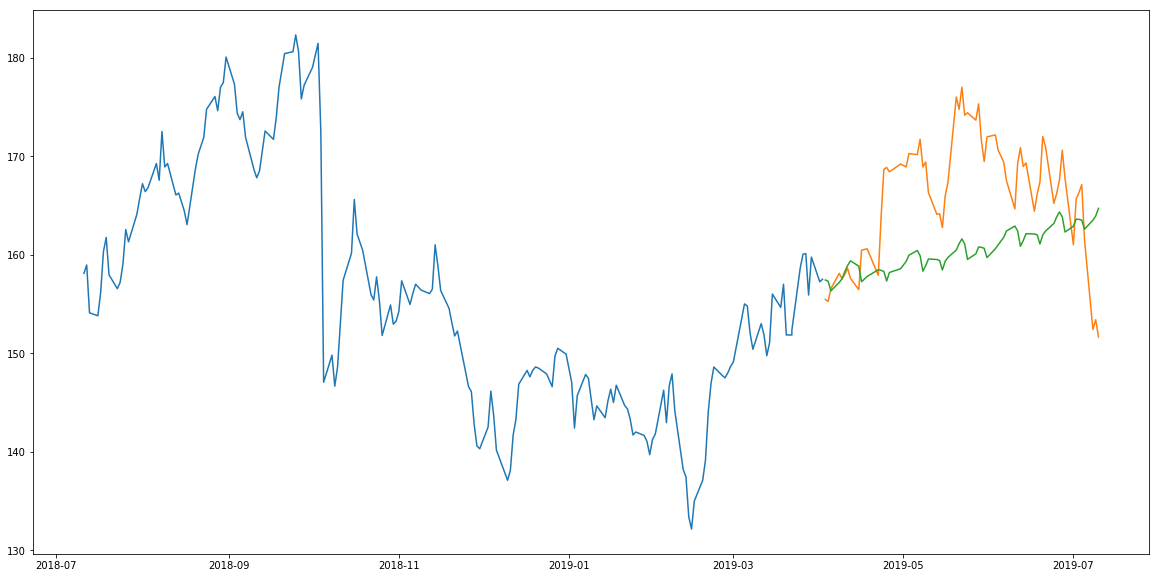

In [0]:
#plot
plt.plot(train['Close Price'])
plt.plot(valid['Close Price'])
plt.plot(forecast['Prediction'])

## Inference:

Using Auto ARIMA the model is predicting in upward trend only. We need to find a more sutable model for this dataset

## FB Prophet

In [0]:
from fbprophet import Prophet

In [0]:
#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close Price'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close Price'][i] = data['Close Price'][i]

new_data['Date'] = pd.to_datetime(new_data.Date)
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close Price': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:180]
valid = new_data[180:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
#rmse
forecast_valid = forecast['yhat'][180:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

7.169823664767851

RMSE score using FB Prophet is reduced as compared to ARIMA. But still the rmse is quite high.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



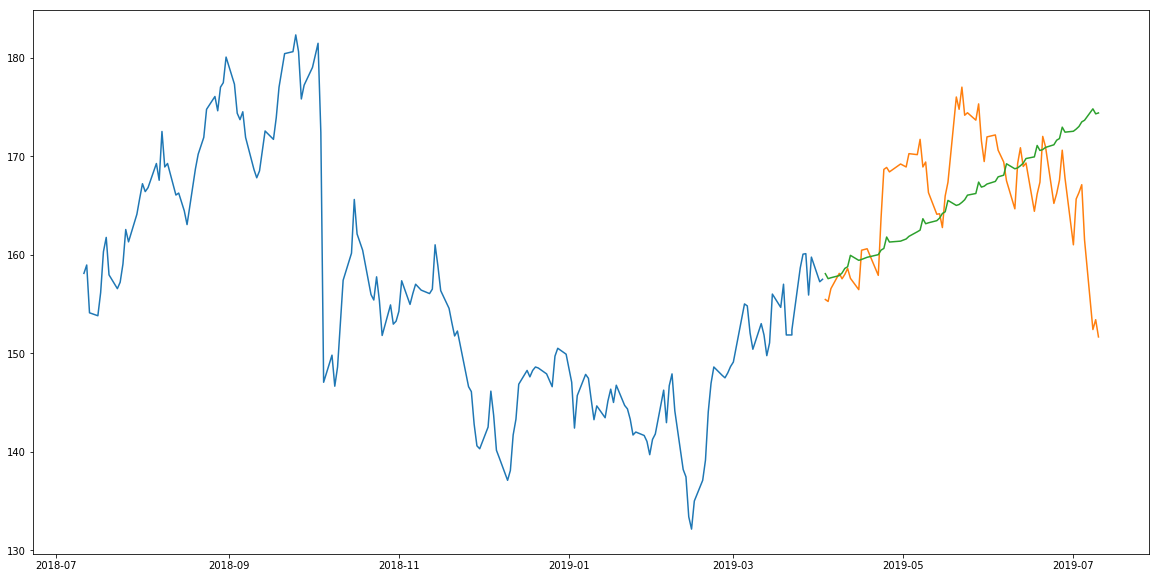

In [0]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

## Inference:

Using FB prophet, we received low RMSE score as compared to received in ARIMA, but even then, after plotting the actual VS predicted graph we can see that model prediction is not very accurate.

## Using LSTM

In [0]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close Price'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close Price'][i] = data['Close Price'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:180,:]
valid = dataset[180:,:]



Using TensorFlow backend.


In [0]:

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(1,len(train)):
    x_train.append(scaled_data[i-1:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=20))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)

#predicting 246 values, using past 1 from the train data
inputs = new_data[len(new_data) - len(valid) - 1:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(1,inputs.shape[0]):
    X_test.append(inputs[i-1:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


Epoch 1/2
 - 4s - loss: 0.1023
Epoch 2/2
 - 1s - loss: 0.0214


In [0]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

Close Price    4.825156
Predictions    2.174609
dtype: float64

RMSE calculated using LSTM is the lowest so far.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



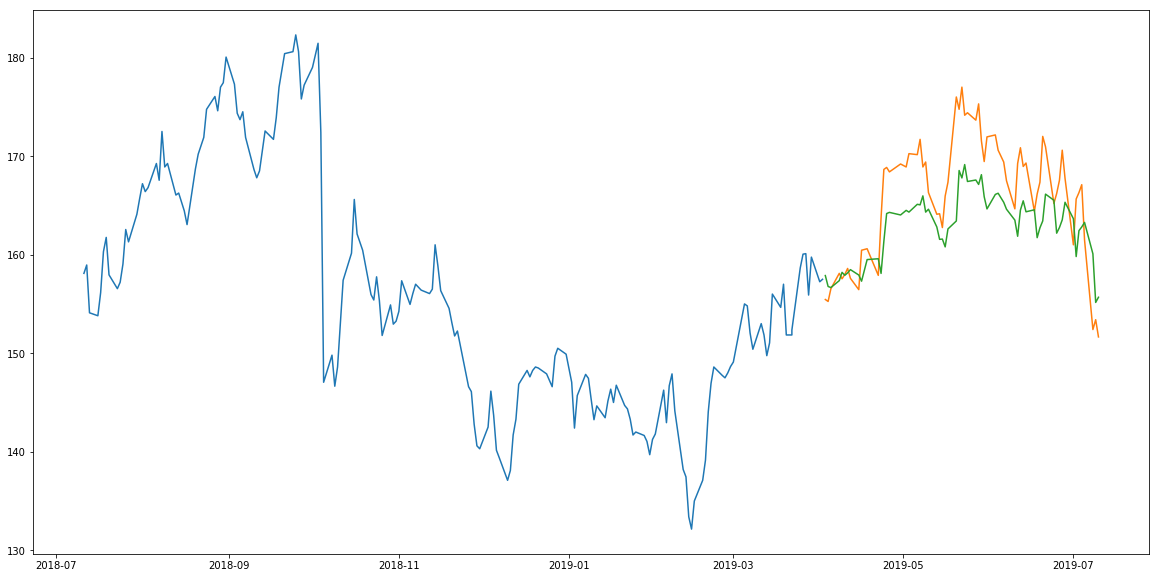

In [0]:
#for plotting
train = new_data[:180]
valid = new_data[180:]
valid['Predictions'] = closing_price
plt.plot(train['Close Price'])
plt.plot(valid[['Close Price','Predictions']])


## Inference:

Using LSTM, in predicting stock price we can see that model learns the pattern very accurately and performs really well